### Importing Libraries

In [1]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Embedding,Bidirectional,LSTM,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import re
import os
import preprocessor as p
from textblob import TextBlob

In [3]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Data Preprocessing

In [4]:
df = pd.read_csv("Trump_No_Retweet_Full_Text.csv",engine="python", encoding= "utf-8",error_bad_lines=False) #Reading CSV

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15725 entries, 0 to 15724
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15725 non-null  object
 1   Tweet_id   15725 non-null  int64 
 2   Verified   15725 non-null  bool  
 3   Tweet      15725 non-null  object
 4   User       15725 non-null  object
 5   Location   11416 non-null  object
 6   Source     15725 non-null  object
 7   Likes      15725 non-null  int64 
 8   Followers  15725 non-null  int64 
 9   Following  15725 non-null  int64 
 10  Retweets   15725 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.2+ MB


In [6]:
df.head(10)

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0
5,2020-07-21 23:58:50,1285725956381052929,False,@Tominatir @rac80 @RodentStill Tonight your Su...,DavidB86318017,NaN,Twitter for iPhone,0,997,2553,0
6,2020-07-21 23:58:38,1285725906200338433,False,Are you really a SPESHUL FORCES soldier for #T...,endalltraitors,"Boring, Oregon",Twitter Web App,1,171,176,0
7,2020-07-21 23:58:36,1285725897765593088,False,"@realDonaldTrump This is what pisses you off, ...",2bahinman,NaN,Twitter Web App,0,521,1099,0
8,2020-07-21 23:58:25,1285725851884179468,True,#Trump supporter pees on the floor rather than...,tomleykis,"Santa Barbara Cty, California",Twitter for Android,7,21339,487,2
9,2020-07-21 23:58:24,1285725848927182849,False,I beg your pardon?! #trump #ghislanemaxwell ht...,marlawhite,"Los Angeles, CA",Twitter for iPhone,0,1343,2057,0


In [7]:
df.drop_duplicates(subset = "Tweet", keep = "first",inplace = True,ignore_index = True) #Removing duplicates

#### Cleaning

In [8]:
tweet_list = []
for x in df["Tweet"]:
    tweet_list.append(p.clean(x)) #Cleaning tweets (Removes URLs, Hashtags, Mentions, Reserved Words (RT,FAV) Emojis, Smileys) and appending to a list
    
tweet_list = [re.sub('[^a-zA-Z]', ' ',i) for i in tweet_list] #Removing punctuatuons

In [9]:
print("----Before----")
print(df["Tweet"][3])

print("----After----")
print(tweet_list[3])

----Before----
Why is #Trump silent when cops beat a #Veteran and put him in the hospital? 

But when a black guy kneels down in #protest he tweets hundreds of times about it? 

☝🏼A good question for the cult.
----After----
Why is silent when cops beat a and put him in the hospital  But when a black guy kneels down in he tweets hundreds of times about it  A good question for the cult 


#### Removing Stopwords

In [10]:
clean_tweets = []
for tweet in tweet_list: 
        for word in set(stopwords.words("english")):
            token = " "+word+" "
            tweet = tweet.replace(token, " ")
        clean_tweets.append(tweet)

In [11]:
clean_tweets[:5]

['You amazing    I hope get support need resist  illegal goon squad ',
 'finally admitted spread coronavirus  get worse  gets better  late joining party  snacks gone  You supposed months ago ',
 'A sure sign party breaking apart start turning  right said would destroy would deserve ',
 'Why silent cops beat put hospital  But black guy kneels tweets hundreds times  A good question cult ',
 'Speaking falling  please careful climbing chairthose phone books youre sitting tricky ']

#### Stemming

In [12]:
stemmed = []
for word in clean_tweets:
    stemmed.append(PorterStemmer().stem(word))

In [13]:
stemmed[:5]

['you amazing    i hope get support need resist  illegal goon squad ',
 'finally admitted spread coronavirus  get worse  gets better  late joining party  snacks gone  you supposed months ago ',
 'a sure sign party breaking apart start turning  right said would destroy would deserve ',
 'why silent cops beat put hospital  but black guy kneels tweets hundreds times  a good question cult ',
 'speaking falling  please careful climbing chairthose phone books youre sitting tricky ']

In [14]:
df["Processed"] = stemmed

### Tfidf Vectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer(ngram_range=(1,1), max_features=150).fit(df["Processed"]) 

trans = vector.transform(df["Processed"])  # Transforming the vectorizer

df_vect=pd.DataFrame(trans.toarray(), columns=vector.get_feature_names()) # Converting to DataFrame

df_vect.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administration,all,also,america,american,americans,amp,and,another,anyone,...,well,what,when,white,why,will,world,would,years,you
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.459912
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.450457
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.788716,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.587316,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.223318,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.432074,0.0,0.000000
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
7,0.0,0.0,0.0,0.0,0.599609,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


### Sentiment Analysis using TextBlob

In [16]:
pol = []

for tweet in df["Processed"]:
    blob = TextBlob(tweet)
    pol.append(blob.sentiment.polarity)
df['Polarity']=pol

In [17]:
df.head(5)

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed,Polarity
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,you amazing i hope get support need resist ...,0.050000
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1,finally admitted spread coronavirus get worse...,-0.050000
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,a sure sign party breaking apart start turning...,0.195238
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,why silent cops beat put hospital but black g...,0.177778
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,speaking falling please careful climbing chai...,-0.100000


#### Segregating into Positive, Negative and Neutral

In [18]:
positive ,negative, neutral = 0,0,0

for polar in df["Polarity"]:
    if polar > 0:
        positive += 1
    elif polar < 0:
        negative += 1
    else:
        neutral += 1
        
pol_list = []

for x in pol:
    if x>0:
        pol_list.append("Positive")
    elif x<0:
        pol_list.append("Negative")
    else:
        pol_list.append("Neutral")
        
df["Sentiment"] = pol_list

In [19]:
print("Positive :",positive)
print("Negative :",negative)
print("Neutral :",neutral)

Positive : 5701
Negative : 4406
Neutral : 5547


In [20]:
sentences = list(df.Processed)
labels = df.Sentiment.tolist()

### NLP

In [21]:
#Converting any float values in the processed tweets into string

ctr2 = 0 
for x in sentences:
    if type(x) == float:
        ctr2 += 1
        sentences[sentences.index(x)] = "nan"                

#### HyperParameters

In [22]:
embedding_dim = 150 
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

#### Splitting Data

In [23]:
train_size = round(training_portion * len(sentences)) 

train_sentences = sentences[:train_size]
train_labels = np.array(labels[:train_size])

validation_sentences = sentences[train_size:]
validation_labels = np.array(labels[train_size:])

#### One Hot Encoding

In [24]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = train_labels.reshape(len(train_labels), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = validation_labels.reshape(len(validation_labels), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [25]:
print(onehot_encoder.categories_)

[array(['Negative', 'Neutral', 'Positive'], dtype='<U8')]


In [26]:
vocab_size = len(set(" ".join(train_sentences).split()))
vocab_size

17475

#### Tokenizing

In [27]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = np.array(pad_sequences(train_sequences,maxlen=max_length,truncating=trunc_type,padding=padding_type))

In [28]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))

print(len(validation_sequences))
print(validation_padded.shape)

3131
(3131, 200)


### Defining Model

In [29]:

model = tf.keras.Sequential([
    
    Embedding(vocab_size,embedding_dim,input_length = max_length),
    Bidirectional(LSTM(256)),
    Dropout(0.5),
    BatchNormalization(),
    Dropout(0.5),
    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 150)          2621250   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              833536    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0

In [30]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=9e-4),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
#Training the Model


history = model.fit(train_padded,
                    onehot_encoded_train,
                    epochs=7,
                    validation_data=(validation_padded,onehot_encoded_val))

Epoch 1/7
392/392 [==============================] - 29s 35ms/step - loss: 0.9838 - accuracy: 0.5438 - val_loss: 0.9449 - val_accuracy: 0.7221
Epoch 2/7
392/392 [==============================] - 12s 30ms/step - loss: 0.4366 - accuracy: 0.8423 - val_loss: 0.5103 - val_accuracy: 0.8042
Epoch 3/7
392/392 [==============================] - 12s 30ms/step - loss: 0.2156 - accuracy: 0.9293 - val_loss: 0.5247 - val_accuracy: 0.8285
Epoch 4/7
392/392 [==============================] - 12s 31ms/step - loss: 0.1363 - accuracy: 0.9566 - val_loss: 0.6028 - val_accuracy: 0.8477
Epoch 5/7
392/392 [==============================] - 15s 37ms/step - loss: 0.0971 - accuracy: 0.9721 - val_loss: 0.7557 - val_accuracy: 0.8413
Epoch 6/7
392/392 [==============================] - 12s 31ms/step - loss: 0.0778 - accuracy: 0.9768 - val_loss: 0.6443 - val_accuracy: 0.8390
Epoch 7/7
392/392 [==============================] - 12s 31ms/step - loss: 0.0662 - accuracy: 0.9814 - val_loss: 0.6750 - val_accuracy: 0.8537

## Results

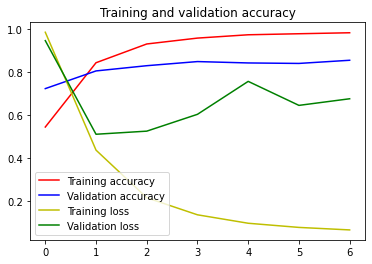

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig('plot.png')

In [33]:
import preprocessor as p

# Tweets for testing the model's actual accuracy


test_tweet = ["As we come closer to #JoeBiden's #VPselection,  I'll support his campaign regardless of who he chooses.  The far right is going to attack whomever he chooses, but his selection will be vastly more qualified than Dan Quayle, Sarah Palin, etc.",
              "So what is Trump doing about Russians' placing a bounty on our American soldiers? Please answer this question immediately",
              "His Plan all along, Dictatorship not in My Country your A$$ is out #JoeBidenPresident is in. Unite Vote Blue America’s Democracy depends on it .",
              "think spreading the is something we all need right now. It would make the World a happier. #JoeBidenPresident #Biden2020 little drawing I made of it",
              "Real Leaders can shut the fuck up every now and then. I've always liked Joe Biden and he wasn't my first choice in the primary but he's grown on me, he's a beautiful person, and I am so proud to be able to vote for him."
             ,"what is biden in front of trump? little bag of scum" ]

test_tweet_clean = []

for line in test_tweet:
    test_tweet_clean.append(p.clean(line))


for i,line in enumerate(test_tweet_clean):             
        for word in stopwords.words("english"):
            token = " "+word+" "
            line = line.replace(token, " ")
        test_tweet_clean[i] = line



a = tokenizer.texts_to_sequences(test_tweet_clean)
a1 = np.array(pad_sequences(a, maxlen = max_length, truncating = trunc_type, padding = padding_type))

## Predictions

In [34]:
predictions = model.predict(a1)

#Displaying results


for j,k in enumerate(predictions):
    m = max(k)
    print(j+1,") ",test_tweet_clean[j])
    if k.tolist().index(m) == 0:
        print("Negative")
    elif k.tolist().index(m) == 1:
        print("Neutral")
    else:
        print("Positive")
    print(" ")

1 )  As come closer 's , I'll support campaign regardless chooses. The far right going attack whomever chooses, selection vastly qualified Dan Quayle, Sarah Palin, etc.
Positive
 
2 )  So Trump Russians' placing bounty American soldiers? Please answer question immediately
Neutral
 
3 )  His Plan along, Dictatorship My Country A$$ in. Unite Vote Blue Americas Democracy depends .
Neutral
 
4 )  think spreading something need right now. It would make World happier. little drawing I made it
Positive
 
5 )  Real Leaders shut fuck every then. I've always liked Joe Biden first choice primary he's grown me, he's beautiful person, I proud able vote him.
Positive
 
6 )  what biden front trump? little bag scum
Negative
 


The model scored 85% validation accuracy, it got the most of the predictions right.